In [2]:
import torch
import numpy as np
from tqdm import tqdm
from scipy.stats.distributions import chi2
from scipy.stats import pearsonr
import pickle

import matplotlib.pyplot as plt
from scipy.stats import linregress
import seaborn as sns
import random
import matplotlib.animation as animation
import sys, os

from utils.plots import *
from utils.funcs import *


from boltzmann_machines.RTRBM import RTRBM
from boltzmann_machines.RTRBM_no_bias import RTRBM_nobias
from boltzmann_machines.RBM import RBM

from data.load_data import *
from data.mock_data import *
from data.reshape_data import *

In [16]:
# Parameters:

N_V = 20
T = 30
N_H = 3
device = 'cpu'
n_rtrbms = 5
n_batches = 500
n_connections = 1

W_list = []
generated = []
trained = []

for _ in range(n_rtrbms):
    U = 2 * np.random.rand(N_H, N_H) - 1
    W = 2 * torch.rand(N_H, N_V) - 1
    sp = 1 - n_connections / N_H

    for i, idx in enumerate(torch.randperm(N_V)):
        if torch.sum(W[:, idx] == 0) / N_H < sp:
            W[:, idx][np.random.permutation(N_H)[:int(np.ceil(sp * N_H))]] = 0

    W_list += [W]
    b_init = torch.zeros(1, N_H, dtype=torch.float, device=device)
    b_V = torch.zeros(1, N_V, dtype=torch.float, device=device)
    b_H = torch.zeros(1, N_H, dtype=torch.float, device=device)

    data = torch.zeros(N_V, T, dtype=torch.float)

    rtrbm = RTRBM(data, N_H=N_H, device='cpu')

    rtrbm.W = torch.tensor(W, device=device, dtype=torch.float)
    rtrbm.U = torch.tensor(U, device=device, dtype=torch.float)
    rtrbm.b_init = b_init
    rtrbm.b_V = b_V
    rtrbm.b_H = b_H

    data = torch.zeros(N_V, T, n_batches)
    rt = torch.zeros(N_H, T, n_batches)
    for batch in tqdm(range(n_batches)):
        v_start = (torch.rand(N_V) > 0.2)*1.0
        data[:, :, batch], rt[:, :, batch] = rtrbm.sample(v_start.type(torch.float), chain=T, pre_gibbs_k=100, gibbs_k=100, mode=1, disable_tqdm=True)

    for sp in [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]:

        rtrbm_nobias = RTRBM_nobias(data, N_H=N_H, device='cpu')
        rtrbm_nobias.learn(n_epochs=2000, lr=1e-3, lr_end=1e-5, start_decay=200, batchsize=100, mom=0.9, wc=0.0002, sp=sp, x=2)

        generated += [rtrbm]
        trained += [rtrbm_nobias]


/tmp/ipykernel_2349178/2576907638.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rtrbm.W = torch.tensor(W, device=device, dtype=torch.float)
100%|██████████| 2000/2000 [1:32:25<00:00,  2.77s/it]


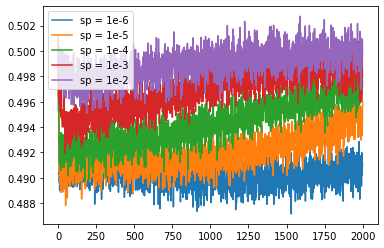

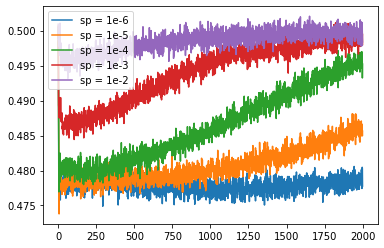

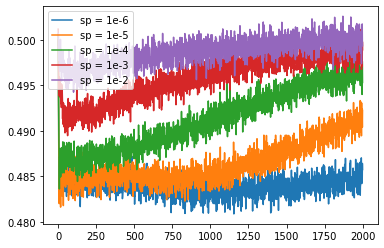

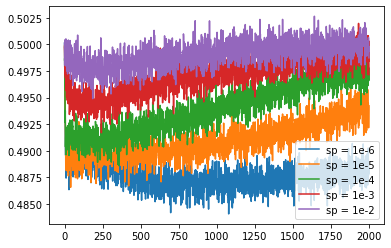

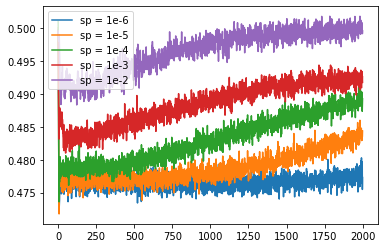

In [19]:
for i in range(25):
    plt.plot(trained[i].errors)
    if (i + 1) % 5 == 0:
        plt.legend(['sp = 1e-6', 'sp = 1e-5', 'sp = 1e-4', 'sp = 1e-3', 'sp = 1e-2'])
        plt.title('')
        plt.show()

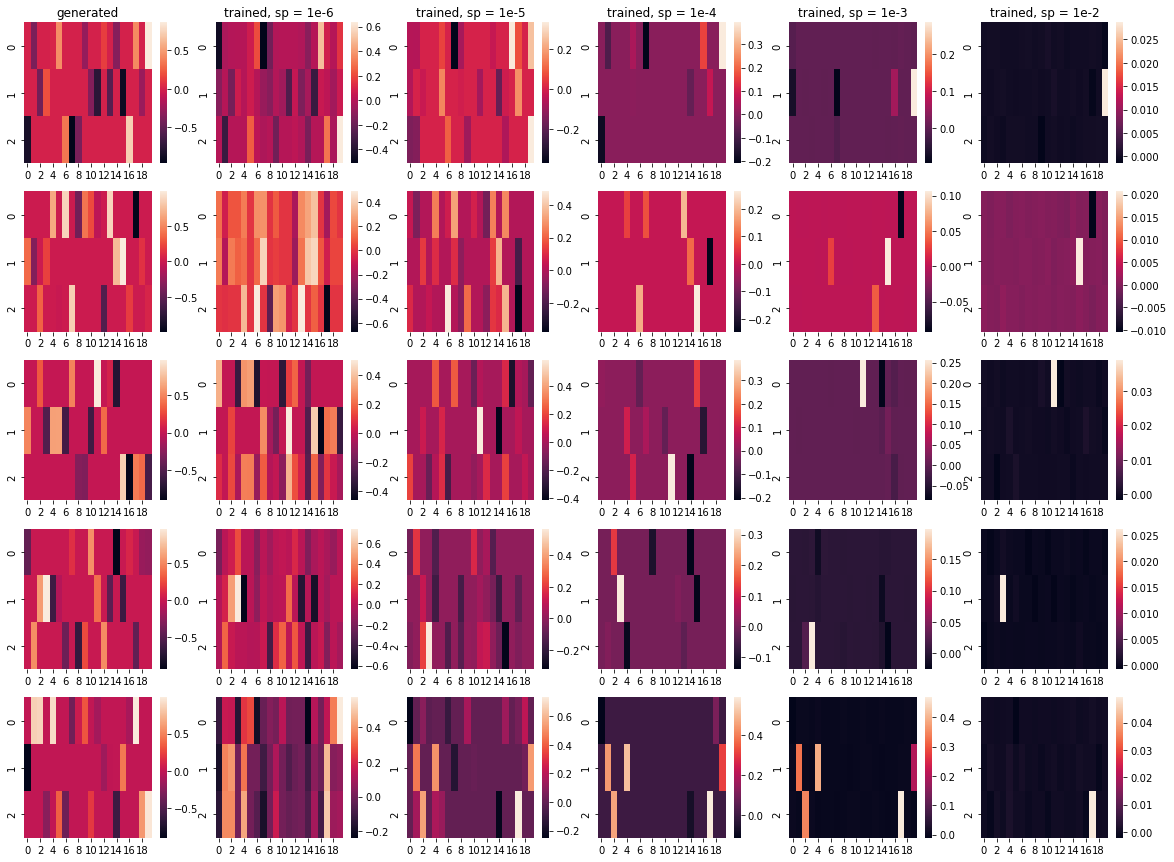

In [23]:
fig, axes = plt.subplots(5, 6, figsize=(20, 15))

for i, ax in enumerate(axes):
    sns.heatmap(generated[5*i].W, ax=ax[0])

    for j in range(5):
        sns.heatmap(trained[5*i + j].W, ax=ax[j+1])
    if i == 0 :
        ax[0].set_title('generated')
        ax[1].set_title('trained, sp = 1e-6')
        ax[2].set_title('trained, sp = 1e-5')
        ax[3].set_title('trained, sp = 1e-4')
        ax[4].set_title('trained, sp = 1e-3')
        ax[5].set_title('trained, sp = 1e-2')

Text(0.5, 0.98, 'Distribution of weights with varying sparsity parameters')

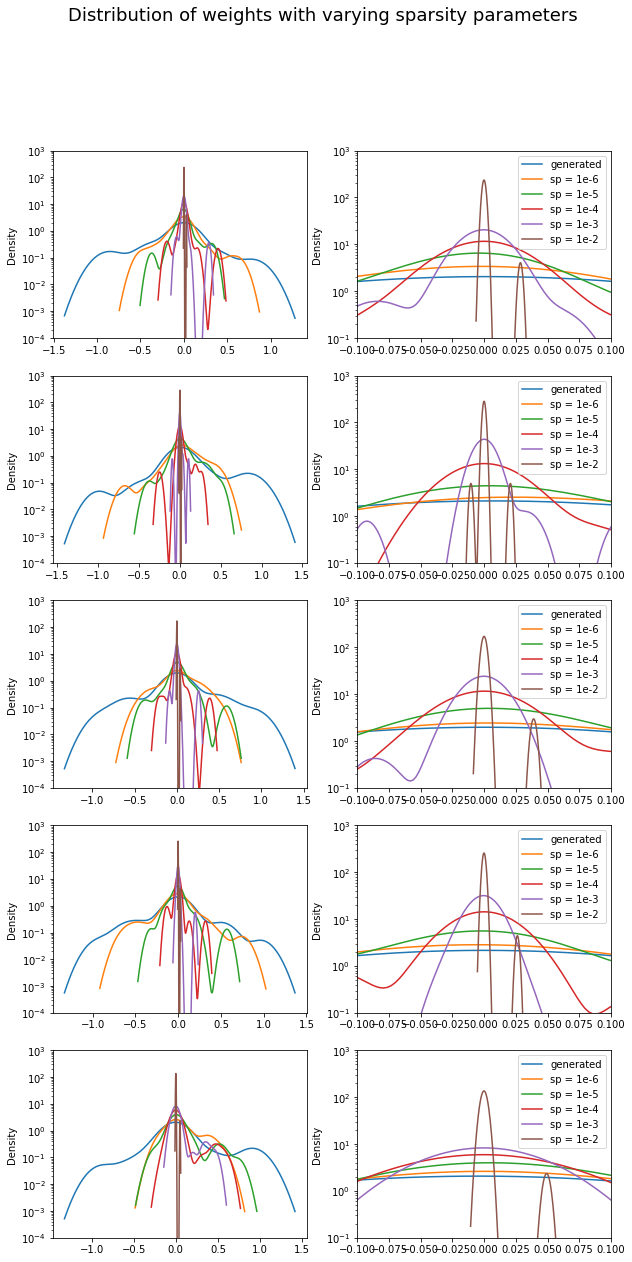

In [46]:
fig, axes = plt.subplots(5, 2, figsize=(10, 20))

for i, ax in enumerate(axes):

    sns.kdeplot(generated[5*i].W.flatten(), ax=ax[0])
    ax[0].set_yscale('log')
    ax[0].set_ylim([1e-4, 1e3])
    for j in range(5):
        sns.kdeplot(trained[5*i + j].W.flatten(), ax=ax[0])


    sns.kdeplot(generated[5*i].W.flatten(), ax=ax[1])
    ax[1].set_yscale('log')
    ax[1].set_ylim([1e-1, 1e3])
    ax[1].set_xlim([-.1, .1])
    for j in range(5):
        sns.kdeplot(trained[5*i + j].W.flatten(), ax=ax[1])

    ax[1].legend(['generated', 'sp = 1e-6', 'sp = 1e-5', 'sp = 1e-4', 'sp = 1e-3', 'sp = 1e-2'])

fig.suptitle('Distribution of weights with varying sparsity parameters', fontsize=18)


In [48]:
import scipy

tensor(0)


Text(0.5, 0, 'Sparsity Parameter')

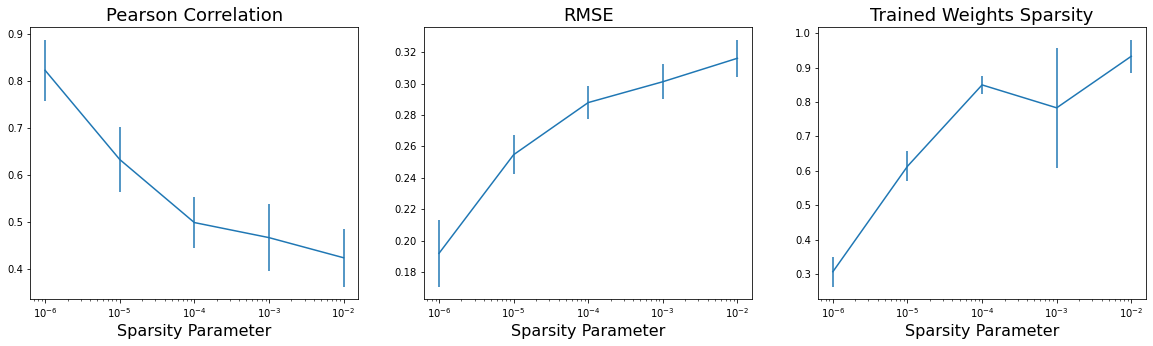

In [62]:
shuffle_idx_possibilities = [[0, 1, 2], [0, 2, 1], [1, 2, 0], [1, 0, 2], [2, 1, 0], [2, 0, 1]]

sparsity = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
W_pearson = torch.zeros(len(sparsity), n_rtrbms, len(shuffle_idx_possibilities))
U_pearson = torch.zeros(len(sparsity), n_rtrbms, len(shuffle_idx_possibilities))

W_error = torch.zeros(len(sparsity), n_rtrbms, len(shuffle_idx_possibilities))
U_error = torch.zeros(len(sparsity), n_rtrbms, len(shuffle_idx_possibilities))

trained_sparsity = torch.zeros(len(sparsity), n_rtrbms)

for n in range(n_rtrbms):
    for i in range(len(sparsity)):
        U_generated = generated[n * 5 + i].W_acc.clone().detach()
        W_generated = generated[n * 5 + i].W.clone().detach()
        W_trained = trained[n * 5 + i].W.clone().detach()
        U_trained = trained[n * 5 + i].W_acc.clone().detach()

        for j, shuffle_idx in enumerate(shuffle_idx_possibilities):
            W_trained_shuffled = W_trained[shuffle_idx, :]
            U_trained_shuffled = U_trained[shuffle_idx, :]
            U_trained_shuffled = U_trained_shuffled[:, shuffle_idx]

            W_pearson[i, n, j], _ = scipy.stats.pearsonr(W_trained_shuffled.ravel(), W_generated.ravel())
            U_pearson[i, n, j], _ = scipy.stats.pearsonr(U_trained_shuffled.ravel(), U_generated.ravel())

            W_error[i, n, j] = RMSE(W_trained_shuffled, W_generated)
            U_error[i, n, j] = RMSE(U_trained_shuffled, U_generated)

        trained_sparsity[i, n] = torch.sum(torch.abs(W_trained) < 1e-3) / W.numel()

W_pearson_best, best_idx1 = torch.max(W_pearson, 2)
U_pearson_best, _ = torch.max(U_pearson, 2)
W_error_best, best_idx2 = torch.min(W_error, 2)
U_error_best, _ = torch.min(U_error, 2)
print(torch.sum(best_idx1 != best_idx2))

W_pearson_mean = torch.mean(W_pearson_best, 1)
U_pearson_mean = torch.mean(U_pearson_best, 1)
W_error_mean = torch.mean(W_error_best, 1)
U_error_mean = torch.mean(U_error_best, 1)
trained_sp_mean = torch.mean(trained_sparsity, 1)

W_pearson_std = torch.std(W_pearson_best, 1)
U_pearson_std = torch.std(U_pearson_best, 1)
W_error_std = torch.std(W_error_best, 1)
U_error_std = torch.std(U_error_best, 1)
trained_sp_std = torch.std(trained_sparsity, 1)


fig, axes = plt.subplots(1, 3, figsize=(20,5))

axes[0].errorbar(sparsity, W_pearson_mean, yerr=W_pearson_std)
axes[1].errorbar(sparsity, W_error_mean, yerr=W_error_std)
axes[2].errorbar(sparsity, trained_sp_mean, trained_sp_std)

axes[0].set_title('Pearson Correlation', fontsize=18)
axes[1].set_title('RMSE', fontsize=18)
axes[2].set_title('Trained Weights Sparsity', fontsize=18)
axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[2].set_xscale('log')
axes[0].set_xlabel('Sparsity Parameter', fontsize=16)
axes[1].set_xlabel('Sparsity Parameter', fontsize=16)
axes[2].set_xlabel('Sparsity Parameter', fontsize=16)